# Spectral Fit using COSIpy Classic
This notebook performs a spectral fit on the Crab nebula and Centaurus A using simulated balloon flight data

## Import packages

We're using the cosipy classic functions in COSIpy.py, response.py, and fit.py

In [1]:
from COSIpy_dc1 import *
import response_dc1
from fit_dc1 import *

Welcome to JupyROOT 6.24/06


/Users/eneights/software/COSItools/external/root_v6.24.06/lib/ROOT/_facade.py:150: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  return _orig_ihook(name, *args, **kwds)


## Define file names

DC1_combined_10x.tra.gz is a simulation of 4 point sources (Crab, Cen A, Cyg X-1, Vela), the 511 keV & Al26 lines, and Ling background

CenA_BG_10x.tra.gz is a simulation of only Cen A and Ling background

The background response was created using a simulation of the Ling background, and it is constant in time

In [2]:
data_dir = '../data_products' # directory containing data & response files
filename_combined = 'DC1_combined_10x.tra.gz' # combined simulation
filename_cena = 'CenA_BG_10x.tra.gz' # Cen A simulation
response_filename = data_dir + '/Continuum_Response.npz' # detector response
background_filename = data_dir + '/Scaled_Ling_BG_1x.npz' # background response
background_mode = 'from file'

## Define variables

You can perform the spectral fit on another point source, such as Cyg X-1 or Vela, by changing the latitude and longitude

In [3]:
l_crab,b_crab = 184.55746, -5.78436 # longitude & latitude of Crab
l_cena,b_cena = 309.51584, 19.41709 # longitude & latitude of Cen A

Delta_T = 7200 # time bin size in seconds
energy_bin_edges = np.array([150,  220,  325,  480,  520,  765, 1120, 1650, 2350, 3450, 5000]) # energy bin edges in keV

pixel_size = 6. # pixel size in degrees
ul = 3 # SNR limit for upper limits on spectral fit

## Read in combined simulation

This cell usually takes a few minutes to run

In [4]:
analysis_combined = COSIpy(data_dir,filename_combined) # create analysis object
analysis_combined.read_COSI_DataSet() # read in data

## Bin combined simulation data

In [5]:
analysis_combined.dataset.time_binning_tags(time_bin_size=Delta_T) # time binning
analysis_combined.dataset.init_binning(energy_bin_edges=energy_bin_edges,pixel_size=pixel_size) # energy and pixel binning
analysis_combined.dataset.get_binned_data() # bin data

## Print binning information for combined simulation

This prints the total time in the dataset, the number of time bins that have counts in them, the maximum time in each time bin, the indices of the time bins that have counts, and the number of counts in each time bin

In [6]:
print('Total time in dataset (s): ' + str(analysis_combined.dataset.times.total_time))
print('Number of populated time bins: ' + str(analysis_combined.dataset.times.n_ph))
print('Maximum time for each bin: ' + str(analysis_combined.dataset.times.times_max))
print('Populated time bins: ' + str(analysis_combined.dataset.times.n_ph_dx))
print('Number of counts in each time bin: ' + str(analysis_combined.dataset.times.n_ph_t))

Total time in dataset (s): 4031996.412727833
Number of populated time bins: 560
Maximum time for each bin: [   7200.           14400.           21600.           28800.
   36000.           43200.           50400.           57600.
   64800.           72000.           79200.           86400.
   93600.          100800.          108000.          115200.
  122400.          129600.          136800.          144000.
  151200.          158400.          165600.          172800.
  180000.          187200.          194400.          201600.
  208800.          216000.          223200.          230400.
  237600.          244800.          252000.          259200.
  266400.          273600.          280800.          288000.
  295200.          302400.          309600.          316800.
  324000.          331200.          338400.          345600.
  352800.          360000.          367200.          374400.
  381600.          388800.          396000.          403200.
  410400.          417600.          424

This prints the shape of the binned data array (time, energy, phi, fisbel (psi/chi))

In [7]:
print(analysis_combined.dataset.binned_data.shape)

(560, 10, 30, 1145)


## Plot raw spectrum & light curve for combined simulation

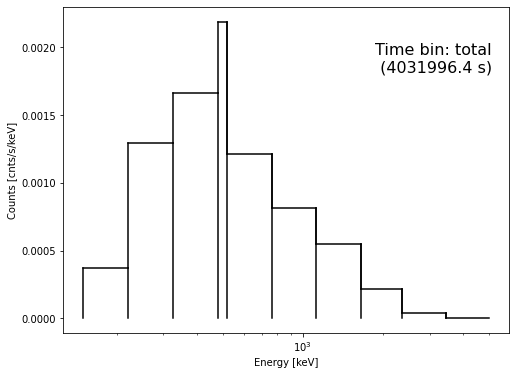

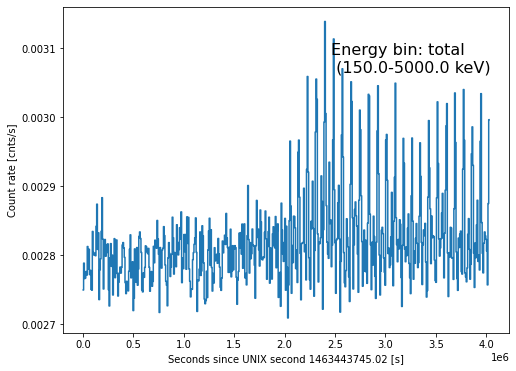

In [8]:
analysis_combined.dataset.plot_raw_spectrum()
plt.xscale('log')

analysis_combined.dataset.plot_lightcurve()

## Define pointings for combined simulation

This cell usually takes a few minutes to run

In [11]:
pointing_combined = Pointing(dataset=analysis_combined.dataset)

This plots the pointings with the location of the Crab in green and Cen A in red

It also plots the elevation of the Crab, then the elevation of Cen A

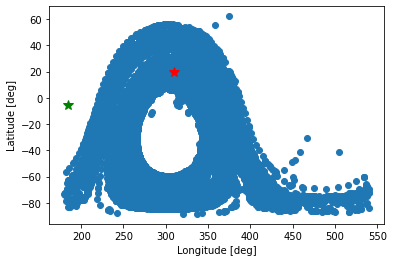

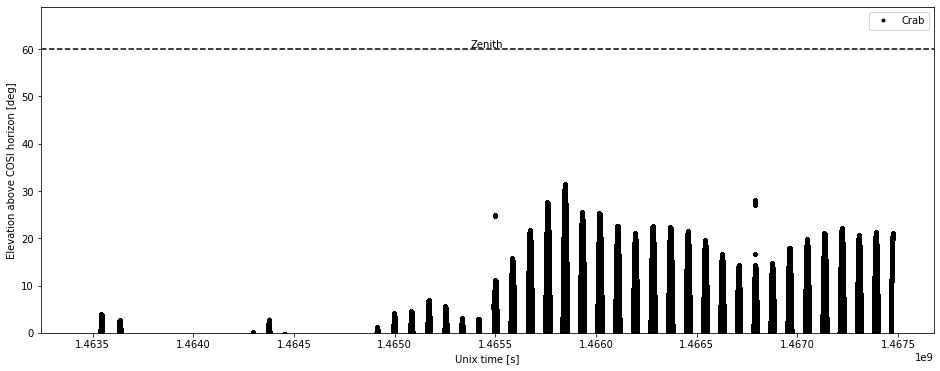

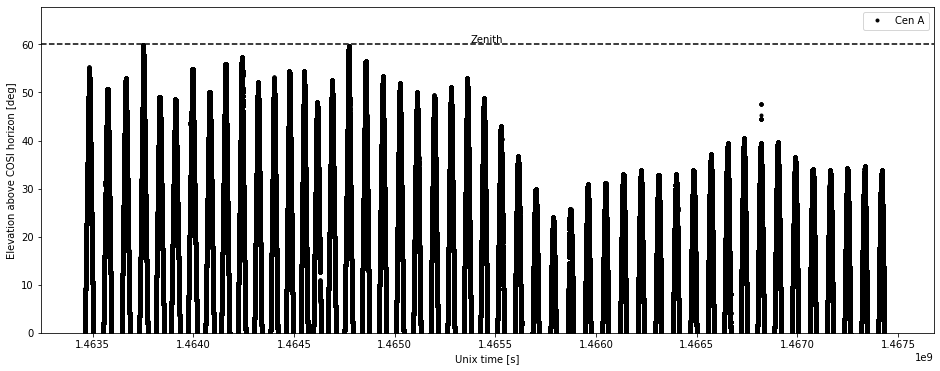

In [16]:
plt.plot(pointing_combined.zpoins[:,0]+360,pointing_combined.zpoins[:,1],'o')
plt.plot(l_crab,b_crab,'*g',markersize=10) # plot Crab location as a green star
plt.plot(l_cena,b_cena,'*r',markersize=10) # plot Cen A location as a red star
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')

analysis_combined.plot_elevation([l_crab],[b_crab],['Crab'])

analysis_combined.plot_elevation([l_cena],[b_cena],['Cen A'])

## Read in background & detector responses for combined simulation

This cell usually takes a few minutes to run

In [17]:
background_combined = BG(dataset=analysis_combined.dataset,mode=background_mode,filename=background_filename) # read in background

print('Reading in response...')
rsp = response.SkyResponse(filename=response_filename,pixel_size=pixel_size) # read in detector response

Using background mode: from file
Reading in response...
Reading complete continuum response. This might take a while...
Done.

Creating general RMF matrices, stay tuned...


Loop over phi bins:: 100%|████████████████████████| 30/30 [00:44<00:00,  1.49s/it]


Done.

Creating general IRF. Wait for it...
Done.

Deleting full matrix.
Done. Now have fun.


This prints the shape of the response matrix (latitude, longitude, phi, fisbel (psi/chi), energy)

In [18]:
rsp.rsp.response_grid_normed_efinal.shape

(30, 60, 30, 1145, 10)

## Calculate point source response for the Crab using combined simulation

In [20]:
rsp.calculate_PS_response(analysis_combined.dataset,pointing_combined,l_crab,b_crab,1,background=background_combined,pixel_size=pixel_size,lookup=False)

Loop over pointings:: 100%|██████████████| 45853/45853 [00:00<00:00, 76595.29it/s]


## Plot binned data light curve and background & sky models for the Crab using combined simulation

The binned data light curve is in blue, the background model is in orange, and the sky model is in green

This is plotted for one energy bin

The y-axis is in counts per time bin for the binned data light curve and the background model. The sky model is normalized to 1

Text(0.5, 0, 'Time Bins')

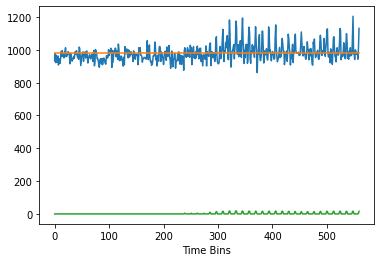

In [24]:
plt.plot(np.sum(analysis_combined.dataset.binned_data[:,1,:,:],axis=(1,2))) # binned data light curve
plt.plot(np.sum(background_combined.bg_model_reduced[1],axis=1)) # background model
plt.plot(np.sum(rsp.sky_response[1],axis=1)*1000) # sky model
plt.xlabel('Time Bins')

## Extract spectrum for Crab using combined simulation

This can take a few hours!

For each energy bin individually, it determines the coefficients for the sky and background models that best match the data

In [28]:
result_crab = fit(analysis_combined.dataset,pointing_combined,rsp,background_combined) # create fitting object
result_crab.fit(iters=2000) # perform spectral fit using emcee (uses pointing definition, background model, & point source response)

Loop over energy bins:: 100%|██████████████████| 10/10 [1:19:22<00:00, 476.23s/it]


This plots the extracted spectrum of the Crab

The first plot includes error bars on each point. The second plot shows upper limits where the SNR > 3 (The Crab should not have any upper limits)

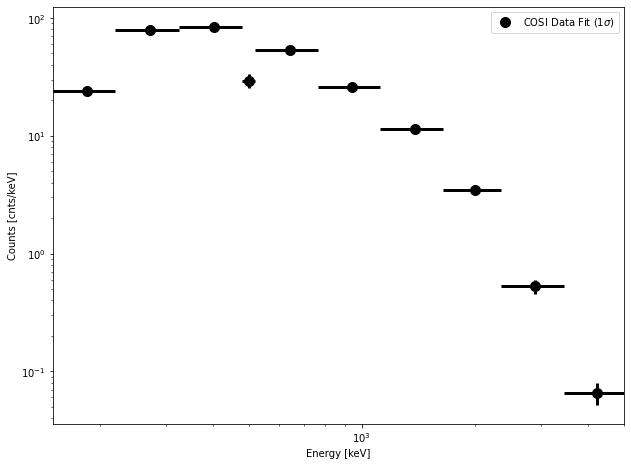

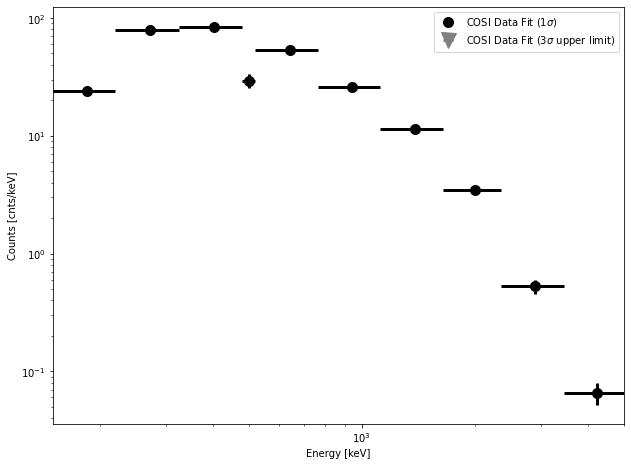

In [30]:
result_crab.plot_extracted_spectrum()
result_crab.plot_extracted_spectrum(ul=ul)

## Calculate point source response for Cen A using combined simulation

In [32]:
rsp.calculate_PS_response(analysis_combined.dataset,pointing_combined,l_cena,b_cena,1,background=background_combined,pixel_size=pixel_size,lookup=False)

Loop over pointings:: 100%|█████████████| 45853/45853 [00:00<00:00, 112551.07it/s]


## Plot binned data light curve and background & sky models for Cen A using combined simulation

The binned data light curve is in blue, the background model is in orange, and the sky model is in green

This is plotted for one energy bin

The y-axis is in counts per time bin for the binned data light curve and the background model. The sky model is normalized to 1

Text(0.5, 0, 'Time Bins')

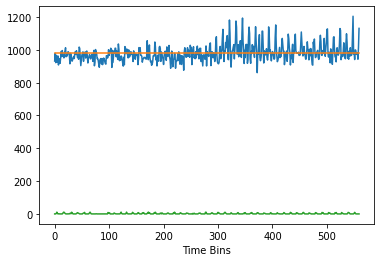

In [34]:
plt.plot(np.sum(analysis_combined.dataset.binned_data[:,1,:,:],axis=(1,2)))
plt.plot(np.sum(background_combined.bg_model_reduced[1],axis=1))
plt.plot(np.sum(rsp.sky_response[1],axis=1)*1000)
plt.xlabel('Time Bins')

## Extract spectrum for Cen A using combined simulation

This can take a few hours!

For each energy bin individually, it determines the coefficients for the sky and background models that best match the data

In [35]:
result_cena = fit(analysis_combined.dataset,pointing_combined,rsp,background_combined) # create fitting object
result_cena.fit(iters=2000) # perform spectral fit using emcee (uses pointing definition, background model, & point source response)

Loop over energy bins:: 100%|██████████████████| 10/10 [1:17:03<00:00, 462.39s/it]


This plots the extracted spectrum of Cen A

The first plot includes error bars on each point. The second plot shows upper limits where the SNR > 3

The error bars for Cen A are very large, and almost all energy bins have upper limits. This is due to the Crab's brightness interfering with the fit. To fix this, we need to include the Crab in the background model. Because the position of the Crab is changing with respect to the detector's field of view, our background model would now be time-dependent. However, our current fitting algorithm only includes one background parameter, so we cannot handle a time-dependent background. Future versions of cosipy will fix this issue

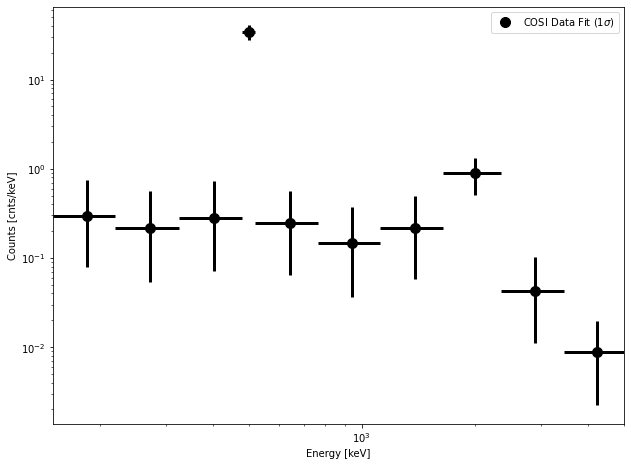

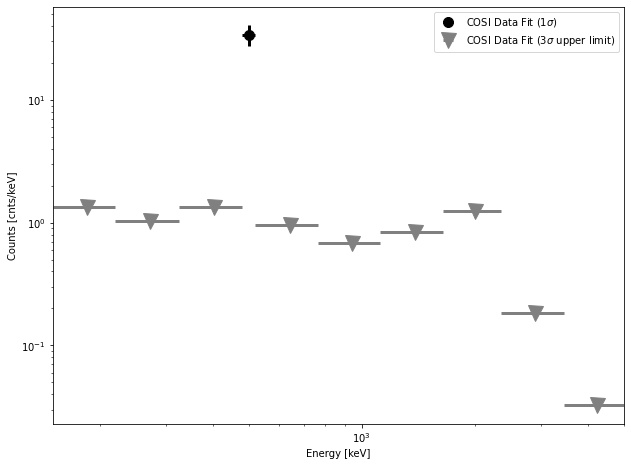

In [36]:
result_cena.plot_extracted_spectrum()
result_cena.plot_extracted_spectrum(ul=ul)

## Read in Cen A simulation

This cell usually takes a few minutes to run

A more accurate spectra of Cen A (without requiring multiple background parameters) can be extracted using a simulation of only Cen A and Ling background

In [37]:
analysis_cena = COSIpy(data_dir,filename_cena) # create analysis object
analysis_cena.read_COSI_DataSet() # read in data

## Bin Cen A simulation data

In [38]:
analysis_cena.dataset.time_binning_tags(time_bin_size=Delta_T) # time binning
analysis_cena.dataset.init_binning(energy_bin_edges=energy_bin_edges,pixel_size=pixel_size) # energy and pixel binning
analysis_cena.dataset.get_binned_data() # bin data

## Print binning information for Cen A simulation

This prints the total time in the dataset, the number of time bins that have counts in them, the maximum time in each time bin, the indices of the time bins that have counts, and the number of counts in each time bin

In [39]:
print('Total time in dataset (s): ' + str(analysis_cena.dataset.times.total_time))
print('Number of populated time bins: ' + str(analysis_cena.dataset.times.n_ph))
print('Maximum time for each bin: ' + str(analysis_cena.dataset.times.times_max))
print('Populated time bins: ' + str(analysis_cena.dataset.times.n_ph_dx))
print('Number of counts in each time bin: ' + str(analysis_cena.dataset.times.n_ph_t))

Total time in dataset (s): 4031996.1804840565
Number of populated time bins: 560
Maximum time for each bin: [   7200.           14400.           21600.           28800.
   36000.           43200.           50400.           57600.
   64800.           72000.           79200.           86400.
   93600.          100800.          108000.          115200.
  122400.          129600.          136800.          144000.
  151200.          158400.          165600.          172800.
  180000.          187200.          194400.          201600.
  208800.          216000.          223200.          230400.
  237600.          244800.          252000.          259200.
  266400.          273600.          280800.          288000.
  295200.          302400.          309600.          316800.
  324000.          331200.          338400.          345600.
  352800.          360000.          367200.          374400.
  381600.          388800.          396000.          403200.
  410400.          417600.          42

This prints the shape of the binned data array (time, energy, phi, fisbel (psi/chi))

In [54]:
print(analysis_cena.dataset.binned_data.shape)

(560, 10, 30, 1145)


## Plot raw spectrum & light curve for Cen A simulation

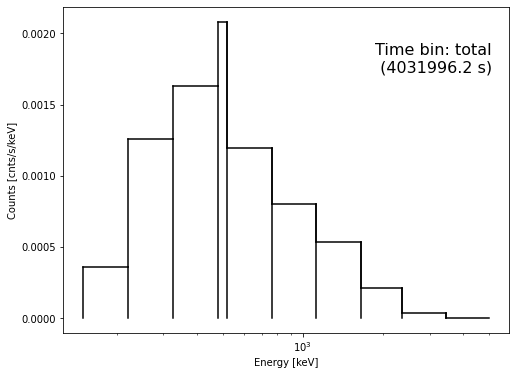

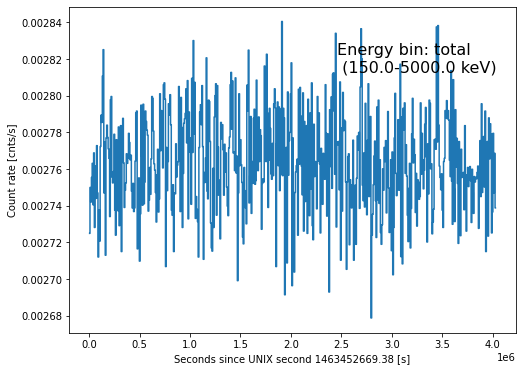

In [41]:
analysis_cena.dataset.plot_raw_spectrum()
plt.xscale('log')

analysis_cena.dataset.plot_lightcurve()

## Define pointings for Cen A simulation

This cell usually takes a few minutes to run

In [44]:
pointing_cena = Pointing(dataset=analysis_cena.dataset)

This plots the pointings with the location of Cen A in red

It also plots the elevation of Cen A

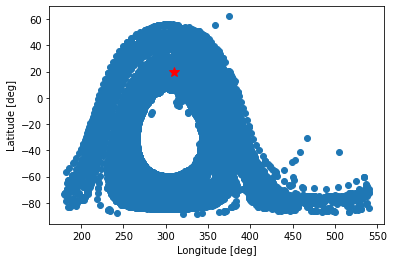

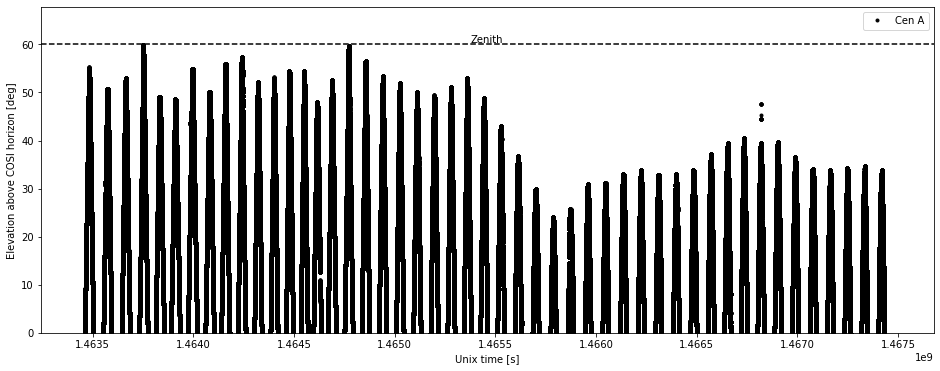

In [45]:
plt.plot(pointing_cena.zpoins[:,0]+360,pointing_cena.zpoins[:,1],'o')
plt.plot(l_cena,b_cena,'*r',markersize=10) # plot Cen A location as a red star
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')

analysis_cena.plot_elevation([l_cena],[b_cena],['Cen A'])

## Read in background response for Cen A simulation

In [46]:
background_cena = BG(dataset=analysis_cena.dataset,mode=background_mode,filename=background_filename) # read in background

Using background mode: from file


## Calculate point source response for Cen A using Cen A simulation

In [47]:
rsp.calculate_PS_response(analysis_cena.dataset,pointing_cena,l_cena,b_cena,1,background=background_cena,pixel_size=pixel_size,lookup=False)

Loop over pointings:: 100%|█████████████| 45844/45844 [00:00<00:00, 114579.65it/s]


## Plot binned data light curve and background & sky models for Cen A using Cen A simulation

The binned data light curve is in blue, the background model is in orange, and the sky model is in green

This is plotted for one energy bin

The y-axis is in counts per time bin for the binned data light curve and the background model. The sky model is normalized to 1

Text(0.5, 0, 'Time Bins')

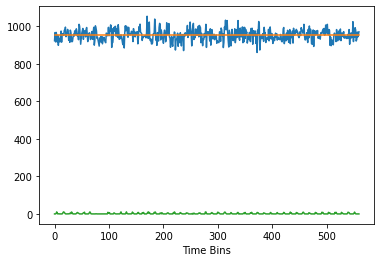

In [48]:
plt.plot(np.sum(analysis_cena.dataset.binned_data[:,1,:,:],axis=(1,2)))
plt.plot(np.sum(background_cena.bg_model_reduced[1],axis=1))
plt.plot(np.sum(rsp.sky_response[1],axis=1)*1000)
plt.xlabel('Time Bins')

## Extract spectrum for Cen A using Cen A simulation

This can take a few hours!

For each energy bin individually, it determines the coefficients for the sky and background models that best match the data

In [50]:
result_cena2 = fit(analysis_cena.dataset,pointing_cena,rsp,background_cena) # create fitting object
result_cena2.fit(iters=2000) # perform spectral fit using emcee (uses pointing definition, background model, & point source response)

Loop over energy bins:: 100%|██████████████████| 10/10 [1:19:27<00:00, 476.71s/it]


This plots the extracted spectrum of Cen A

The first plot includes error bars on each point. The second plot shows upper limits where the SNR > 3

Without the Crab in the simulation, the error bars are smaller, and it is very similar to the spectrum inputted into the simulation

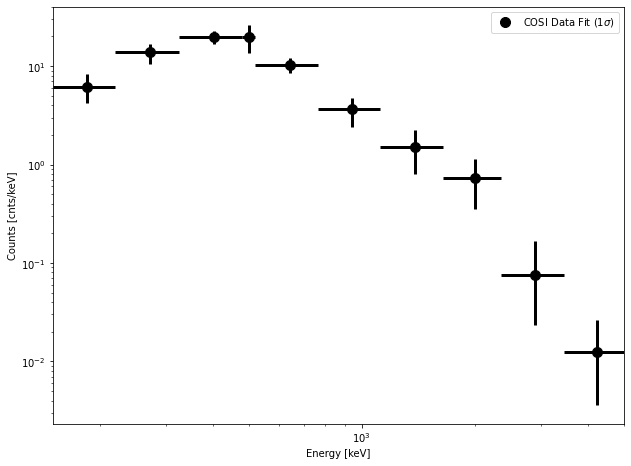

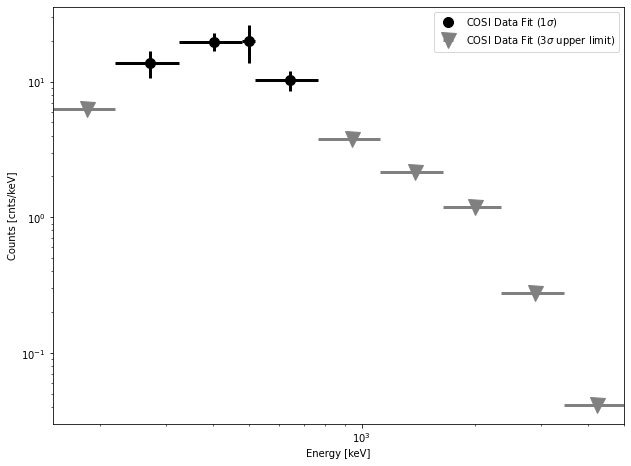

In [52]:
result_cena2.plot_extracted_spectrum()
result_cena2.plot_extracted_spectrum(ul=ul)